In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
os.chdir('/home/maggie1999424/Downloads/MSI2/classification/')
from nat import *
from dinat import *
from dinats import *
from isotropic import *
from extras import get_gflops, get_mparams
from timm.data import create_loader, resolve_data_config, Mixup, FastCollateMixup, AugMixDataset
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
        model_parameters
    # convert_splitbn_model,
from timm.utils import *
from timm.loss import *
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm.scheduler import *
from timm.utils import ApexScaler, NativeScaler
os.chdir('/home/maggie1999424/Downloads/MSI2')


cudnn.benchmark = True
plt.ion()   # interactive mode

/home/maggie1999424/miniconda3/envs/NA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



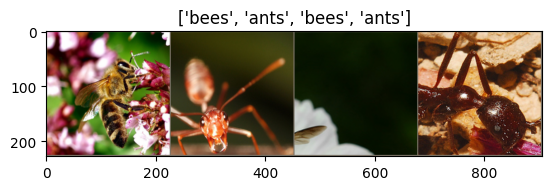

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [7]:

model_ft = create_model('nat_mini',num_classes = 2)
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, 2)

In [8]:
model_ft.to(device)

NAT(
  (patch_embed): ConvTokenizer(
    (proj): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (levels): ModuleList(
    (0): NATBlock(
      (blocks): ModuleList(
        (0): NATLayer(
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attn): NeighborhoodAttention2D(
            head_dim=32, num_heads=2, kernel_size=7, dilation=1, rel_pos_bias=True
            (qkv): Linear(in_features=64, out_features=192, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=64, out_features=64, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
     

In [9]:
# model_ft = models.resnet18(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.00001,)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6810 Acc: 0.5656
val Loss: 0.6850 Acc: 0.5294

Epoch 1/24
----------
train Loss: 0.6978 Acc: 0.5492
val Loss: 0.6841 Acc: 0.5359

Epoch 2/24
----------
train Loss: 0.6800 Acc: 0.5984
val Loss: 0.6833 Acc: 0.5229

Epoch 3/24
----------
train Loss: 0.6828 Acc: 0.5451
val Loss: 0.6828 Acc: 0.5425

Epoch 4/24
----------
train Loss: 0.6855 Acc: 0.5738
val Loss: 0.6825 Acc: 0.5490

Epoch 5/24
----------
train Loss: 0.6781 Acc: 0.5697
val Loss: 0.6823 Acc: 0.5686

Epoch 6/24
----------
train Loss: 0.6826 Acc: 0.5779
val Loss: 0.6824 Acc: 0.5621

Epoch 7/24
----------
train Loss: 0.6742 Acc: 0.5779
val Loss: 0.6824 Acc: 0.5621

Epoch 8/24
----------
train Loss: 0.6769 Acc: 0.5861
val Loss: 0.6823 Acc: 0.5621

Epoch 9/24
----------
train Loss: 0.6735 Acc: 0.5656
val Loss: 0.6824 Acc: 0.5621

Epoch 10/24
----------
train Loss: 0.6750 Acc: 0.5902
val Loss: 0.6824 Acc: 0.5621

Epoch 11/24
----------
train Loss: 0.6806 Acc: 0.5861
val Loss: 0.6824 Acc: 0.5621

Ep

tensor([[0.7491, 0.1687],
        [0.2635, 0.2088],
        [0.8488, 0.5010],
        [0.5190, 0.3140]], device='cuda:0')


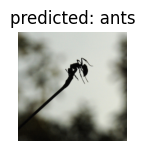

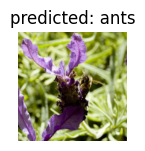

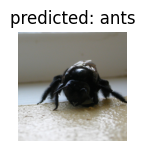

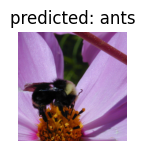

tensor([[ 0.3076,  0.4054],
        [ 0.3230,  0.5497],
        [ 0.1540,  0.3368],
        [-0.0434,  0.2758]], device='cuda:0')


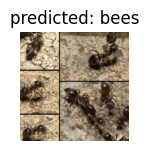

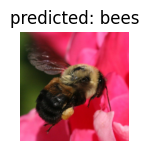

In [13]:
visualize_model(model_ft)

In [12]:
a = model(**inputs, output_hidden_states = True)

TypeError: <module 'timm.utils.model' from '/home/maggie1999424/miniconda3/envs/NA/lib/python3.11/site-packages/timm/utils/model.py'> argument after ** must be a mapping, not Tensor

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [18]:
# model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model_conv = create_model('nat_mini',pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.head.in_features
model_conv.head = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.head.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2303 Acc: 0.9262
val Loss: 0.0449 Acc: 0.9869

Epoch 1/24
----------
train Loss: 0.0732 Acc: 0.9877
val Loss: 0.0302 Acc: 0.9869

Epoch 2/24
----------
train Loss: 0.0791 Acc: 0.9713
val Loss: 0.0249 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0821 Acc: 0.9549
val Loss: 0.0232 Acc: 0.9869

Epoch 4/24
----------
train Loss: 0.0644 Acc: 0.9795
val Loss: 0.0208 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0574 Acc: 0.9836
val Loss: 0.0193 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0651 Acc: 0.9795
val Loss: 0.0187 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0598 Acc: 0.9877
val Loss: 0.0189 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0533 Acc: 0.9877
val Loss: 0.0187 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0489 Acc: 0.9877
val Loss: 0.0187 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0406 Acc: 0.9836
val Loss: 0.0185 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0473 Acc: 0.9836
val Loss: 0.0183 Acc: 1.0000

Ep

tensor([[-3.0626,  2.5783],
        [ 0.8645, -1.5205],
        [ 0.4962, -0.6781],
        [-2.1366,  1.9017]], device='cuda:0')


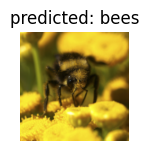

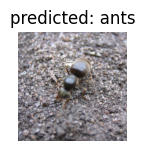

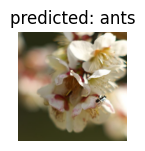

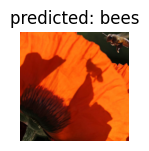

tensor([[-3.2007,  2.8424],
        [ 2.5682, -3.2619],
        [ 3.1128, -3.1932],
        [-3.1198,  2.4456]], device='cuda:0')


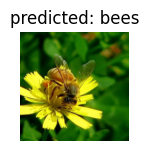

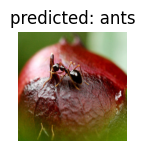

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        
        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



